In [1]:
import sys ###kldmcl1header
sys.path.append('../scripts/')
from mcl import *
from scipy.stats import chi2  #追加

In [2]:
class KldMcl(Mcl):  ###kldmcl1kldmclinit
    def __init__(self, envmap, init_pose, max_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05, 
                widths = np.array([0.2, 0.2, math.pi/18]).T, epsilon=0.1, delta=0.01): #パーティクル数numをmax_numに。KLD用のパラメータを追加
        super().__init__(envmap, init_pose, 1, motion_noise_stds, distance_dev_rate, direction_dev) #最初のパーティクルを1個に
        self.widths = widths                #各ビンのxyθの幅
        self.max_num = max_num     #パーティクル数の上限
        self.epsilon = epsilon              #ε
        self.delta = delta                    #δ
        self.binnum = 0         #ビンの数k。本来、ローカルの変数で良いけど描画用にオブジェクトに持たせておく
        
    def motion_update(self, nu, omega, time):   ###kldmcl1kldmclmotion
        ws = [e.weight for e in self.particles]    # 重みのリストを作る
        if sum(ws) < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
        
        new_particles = [] #新しいパーティクルのリスト（最終的にself.particlesになる）
        bins = set()             #ビンのインデックスを登録しておくセット
        for i in range(self.max_num):
            chosen_p = random.choices(self.particles, weights=ws)  #1つだけ選ぶ（リストに1個だけ入っている）
            p = copy.deepcopy(chosen_p[0])
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)  #移動
            bins.add(tuple(math.floor(e) for e in p.pose/self.widths))               #ビンのインデックスをsetに登録（角度を正規化するとより良い）
            new_particles.append(p)                                                                       #新しいパーティクルのリストに追加
            
            self.binnum = len(bins) if len(bins) > 1 else 2     #ビンの数が1の場合2にしないと次の行の計算ができない
            if  len(new_particles) > math.ceil(chi2.ppf(1.0 - self.delta, self.binnum-1)/(2*self.epsilon)):
                break
            
        self.particles = new_particles
        for i in range(len(self.particles)): #正規化
            self.particles[i].weight = 1.0/len(self.particles)
            
    def observation_update(self, observation):    ###kldmcl1kldmclafter（最後の行まで）
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml()
#     self.resampling()             #motion_updateでリサンプリングするので削除

    def draw(self, ax, elems):  
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, -4.5, "paricle:{}, bin:{}".format(len(self.particles), self.binnum), fontsize=10)) #パーティクルとビンの数を表示

<IPython.core.display.Javascript object>


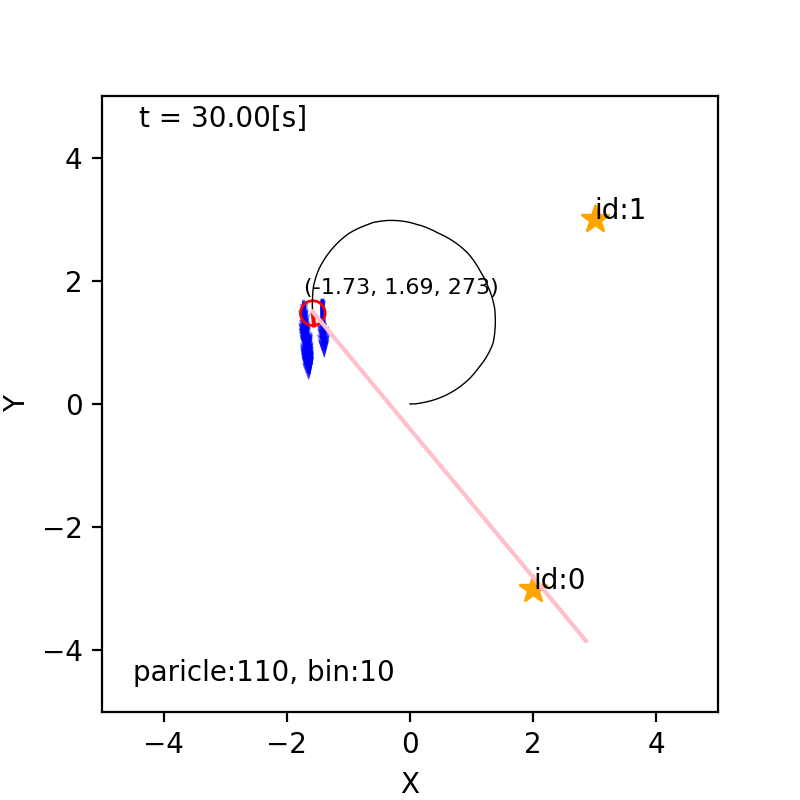

In [3]:
if __name__ == '__main__':  ###kldmcl1exec
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ## 地図を生成して2つランドマークを追加 ##  #一つランドマークを減らしておきましょう
    m = Map()
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##
    initial_pose = np.array([0, 0, 0]).T
    pf = KldMcl(m, initial_pose, 1000, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2})#KldMclにする
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf) 
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [4]:
tuple( math.floor(e) for e in np.array([-0.1, 2.1, 3.0]).T/np.array([0.2, 0.2, math.pi/18]).T ) ###kldmclindex

(-1, 10, 17)